# INF367 - Project 1

- Deadline: Sunday, 29.09.19, 23.59
- Submission details: Jupyter-notebook
- Deliver here [MittUIB.no/assignments](MittUIB.no/assignments)

Projects are a compulsory part of the course. This project contributes 20% to the final grade. The grade will be based good choice of methods, correctness of answers, clarity of code and thoroughness and clarity of reporting. 

*Deliverables:* A jupyter notebook containing all the code to reproduce your work and a report of all your methodological choices and results. 

**NOTE:** This project is a learning experience. If we see that you have copied your answers from online resources, you will get 0 points. 
This is an combined implementation/application project, that means you may only use standard libraries such as numpy and matplotlib for the implementation tasks, but you may use any freely available library for the application tasks of the project.  

## Task 1 - Read on isolation forest 

Read pages 1-15 of the paper on isolation forests <cite data-cite="IsolationForest">(Liu et al, 2012)</cite>. 

- Explain the main difference between isolation forests and density-based approaches. 
- In your own words, explain how the normalization constant $c(\psi)$ is calculated. 
- Discuss the scalability of isolation forests for large datasets. 

### Task 1 - Solution
* Isolation Forest is not trying to estimate the density of the data. Rather assumes that datapoints in dense areas are hard to isolate
* $c(\psi)$ is how deep could isolation tree grow for $\psi$ number of samples. Because isolation trees have the same structure as binary search trees this number is the same as the number of unsuccessful search in BST.
* Isolation Forest is highly scalable. It's creating simple ensemble on relatively small subsets from a dataset. Because of that time complexity is based just on the number of simple components and size of the subsets.

## Task 2 - Implement isolation forest (implementation task)

Write your own class to train and evaluate an isolation forest. In addition to standard libraries such as numpy and matplotlib, you may import a simple tree structure package.

### Task 2 - solution

In [1]:
# Black auto-formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import Optional, List, Union

import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(0)

<IPython.core.display.Javascript object>

In [4]:
def c_norm(n: int) -> float:
    if n > 2:
        return 2 * (np.log(n - 1) + np.euler_gamma) - 2 * (n - 1) / n
    elif n == 2:
        return 1.0
    return 0.0


@dataclass
class IsolationTree:
    max_depth: int
    current_depth: int = 0

    __split_feat_index: int = field(init=False, default=-1, repr=None)
    __split_value: np.float = field(init=False, default=np.nan, repr=None)

    __c: float = field(init=False, default=np.nan, repr=None)

    __left_child: Optional[IsolationTree] = field(init=False, default=None, repr=None)
    __right_child: Optional[IsolationTree] = field(init=False, default=None, repr=None)

    def fit(self, X: np.ndarray) -> IsolationTree:

        if self.current_depth < self.max_depth and X.shape[0] > 1:
            self.__split_feat_index = np.random.choice(X.shape[1])

            s_feat = X[:, self.__split_feat_index]

            feat_min = s_feat.min()
            feat_max = s_feat.max()

            self.__split_value = feat_min + np.random.random() * (feat_max - feat_min)

            self.__left_child = IsolationTree(
                max_depth=self.max_depth, current_depth=self.current_depth + 1
            ).fit(X[s_feat < self.__split_value])

            self.__right_child = IsolationTree(
                max_depth=self.max_depth, current_depth=self.current_depth + 1
            ).fit(X[s_feat >= self.__split_value])
        else:
            self.__c = c_norm(X.shape[0])

        return self

    def path_length(self, X: np.ndarray) -> np.ndarray:
        res = np.zeros(X.shape[0])

        if self.__split_feat_index == -1:
            return np.full(X.shape[0], self.current_depth) + self.__c
        else:
            s_feat = X[:, self.__split_feat_index]

            left_mask = s_feat < self.__split_value
            right_mask = s_feat >= self.__split_value

            res[left_mask] = self.__left_child.path_length(X[left_mask])
            res[right_mask] = self.__right_child.path_length(X[right_mask])

        return res

<IPython.core.display.Javascript object>

In [5]:
@dataclass
class IsolationForest:
    n_estimators: int
    max_samples: int = 256

    estimators_: List[IsolationTree] = field(init=False, repr=None)
    __c: float = field(init=False, repr=None)

    def __post_init__(self):
        max_depth = np.ceil(np.log2(self.max_samples)).astype(int)
        self.estimators_ = [
            IsolationTree(max_depth=max_depth) for _ in range(self.n_estimators)
        ]

        self.__c = c_norm(self.max_samples)

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y=None) -> IsolationForest:

        if isinstance(X, pd.DataFrame):
            X = X.values

        for estimator in self.estimators_:
            estimator.fit(
                X[np.random.choice(X.shape[0], self.max_samples, replace=False)]
            )

        return self

    def __mean_path_length(self, X: np.ndarray) -> np.ndarray:
        return np.mean(
            [estimator.path_length(X) for estimator in self.estimators_], axis=0
        )

    def paper_score_samples(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """ Original scoring proposed in IsolationForest paper
        """

        if isinstance(X, pd.DataFrame):
            X = X.values

        return np.power(2, -self.__mean_path_length(X) / self.__c)

    def score_samples(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """ Negative score, used in Scikit-learn
        """

        return -self.paper_score_samples(X)

<IPython.core.display.Javascript object>

## Task 3 - Preprocessing and density estimation (application task)

In the next task, you will apply the isolation forest on credit card fraud data. 

The datasets contain transactions made by credit cards that occurred in two days in 2013 and a total of 284,807 transactions. The dataset is highly unbalanced, and frauds account for less than 0.2% of all transactions. You will use the training dataset to train the anomaly detection model and the validation dataset to validate it. The training dataset does not contain labels and contains both normal data and anomalies. The validation dataset is labeled with a 'Class' label. 

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. All other features are anonymized through some scaling and dimensionality reduction. 

In this task you summarize and visualize the data and prepare it for analysis. 

- Check for any missing values and handle these appropriately. 
- Find the ranges and basic statistics of the features and rescale them if appropriate. 
- Visualize the univariate densities of all features using your favorite density estimator. Select hyperparameters via cross-validation.
- Calculate basic bivariate statistics, such as correlations.
- Perform any other appropriate preprocessing steps. 

Discuss the results of your summaries and visualization efforts and explain your preprocessing choices. 

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

plt.rcParams["figure.figsize"] = (15, 5)
%matplotlib inline

<IPython.core.display.Javascript object>

In [7]:
train_frame = pd.read_csv("credit-card-fraud-train.csv", index_col="Time", engine="c")

<IPython.core.display.Javascript object>

#### Checking missing values
* there are no missing values in dataset

In [8]:
# Check missing values
all(train_frame.isnull().sum() == 0)

True

<IPython.core.display.Javascript object>

#### Basic statistics for dataset
* features V1-V28 have mean ~0 and standard deviation ~1
* The amount is very different from the rest of the features

In [9]:
desc = train_frame.describe()
for indexes in np.array_split(desc.columns, 4):
    display(HTML(desc[indexes].to_html()))

,V1,V2,V3,V4,V5,V6,V7,V8
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,-0.002918,0.001007,-0.000776,-0.000657,0.003623,-0.000413,0.003383,-0.000037
std,1.961579,1.650818,1.521234,1.416369,1.382186,1.333959,1.243499,1.199284
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718
25%,-0.921714,-0.595751,-0.890062,-0.849442,-0.687217,-0.768676,-0.551287,-0.209168
50%,0.011417,0.066880,0.180284,-0.020854,-0.049806,-0.275498,0.042988,0.021617
75%,1.314504,0.804670,1.026521,0.742483,0.614059,0.397160,0.573937,0.327050
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208


,V9,V10,V11,V12,V13,V14,V15
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,-0.003201,-0.000039,0.000253,0.001207,0.000098,-0.001008,0.000037
std,1.099904,1.094266,1.022240,1.000266,0.994232,0.960919,0.914509
min,-13.320155,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945
25%,-0.647233,-0.535402,-0.764517,-0.401906,-0.647581,-0.425632,-0.582895
50%,-0.053786,-0.093749,-0.033530,0.140764,-0.012488,0.050731,0.047190
75%,0.593482,0.453303,0.741660,0.618867,0.661857,0.492895,0.648349
max,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742


,V16,V17,V18,V19,V20,V21,V22
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,-0.000561,-0.003073,-0.000772,0.000333,-0.000506,-0.000317,-0.000737
std,0.877154,0.853828,0.837800,0.813253,0.772405,0.736680,0.725948
min,-14.129855,-24.019099,-9.498746,-6.938297,-54.497720,-34.830382,-9.499423
25%,-0.468479,-0.485429,-0.498749,-0.455958,-0.211426,-0.228587,-0.542743
50%,0.066556,-0.067066,-0.003206,0.004933,-0.062265,-0.029590,0.005457
75%,0.522626,0.396602,0.500567,0.459135,0.132836,0.186350,0.527898
max,17.315112,8.538195,4.712398,5.591971,38.117209,27.202839,10.503090


,V23,V24,V25,V26,V27,V28,Amount
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,0.000243,0.000740,-0.000020,-0.000703,-0.000241,0.000770,88.235355
std,0.612030,0.606485,0.521657,0.482197,0.406114,0.337554,249.490166
min,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-0.161767,-0.354146,-0.316986,-0.327458,-0.070758,-0.052931,5.510000
50%,-0.011396,0.041572,0.016702,-0.052650,0.001393,0.011388,22.000000
75%,0.147295,0.441354,0.350724,0.239794,0.091404,0.078888,77.000000
max,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


<IPython.core.display.Javascript object>

* In normal distribution we expect certain percetange of point to be in $\mu +- x *\sigma$ ranges (image bellow)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/1200px-Standard_deviation_diagram.svg.png" alt="standard-deviation" style="width: 500px;"/>


In [10]:
means = train_frame.mean()
stds = train_frame.std()

pd.DataFrame(
    np.array(
        [
            (
                (
                    (train_frame > means - i * stds) & (train_frame < means + i * stds)
                ).sum()
                / train_frame.shape[0]
            ).values
            for i in np.arange(0.5, 3.5, 0.5)
        ]
    ).T,
    columns=[f"std {i}" for i in np.arange(0.5, 3.5, 0.5)],
    index=train_frame.columns,
)

,std 0.5,std 1.0,std 1.5,std 2.0,std 2.5,std 3.0
V1,0.352468,0.771761,0.951466,0.970633,0.981157,0.987135
V2,0.564982,0.868823,0.941073,0.965169,0.977416,0.984851
V3,0.404855,0.726823,0.910971,0.972707,0.988273,0.992992
V4,0.445355,0.750099,0.881159,0.943606,0.971532,0.989129
V5,0.523059,0.810281,0.921495,0.964748,0.982430,0.989677
V6,0.506491,0.826371,0.909033,0.930006,0.957548,0.983685
V7,0.547735,0.862971,0.951172,0.974167,0.983086,0.988146
V8,0.784701,0.926242,0.958685,0.971756,0.981232,0.985356
V9,0.453435,0.731781,0.879993,0.950680,0.982842,0.991817
V10,0.528934,0.811105,0.936921,0.973587,0.983245,0.987833


<IPython.core.display.Javascript object>

* Some of the features have a high density around mean (Amount: > 90% in the range $\mu +- \sigma$)
* We could check this by using histograms
    * Number of bins/binwidth could be computed by [histogram_bin_edges](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges) (Freedman Diaconis Estimator) but because we have over $2 * 10^5$ samples methods for big datasets will produce very a large number of bins for every feature
    * We could either sub-sample the dataset or use smaller number of bins

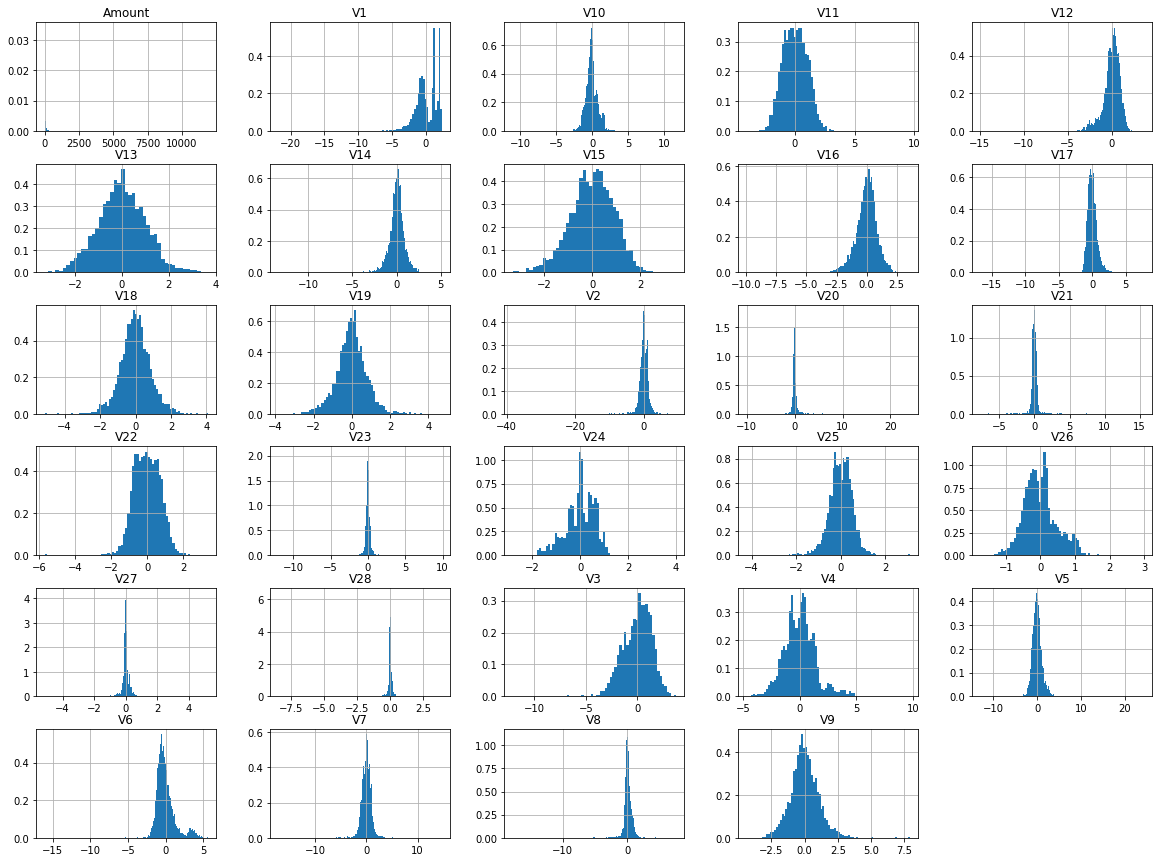

<IPython.core.display.Javascript object>

In [11]:
train_frame.sample(5000).hist(bins="auto", figsize=(20, 15), density=True)
plt.show()

* Because of significant differences in bin hights, it's better to use a log scale

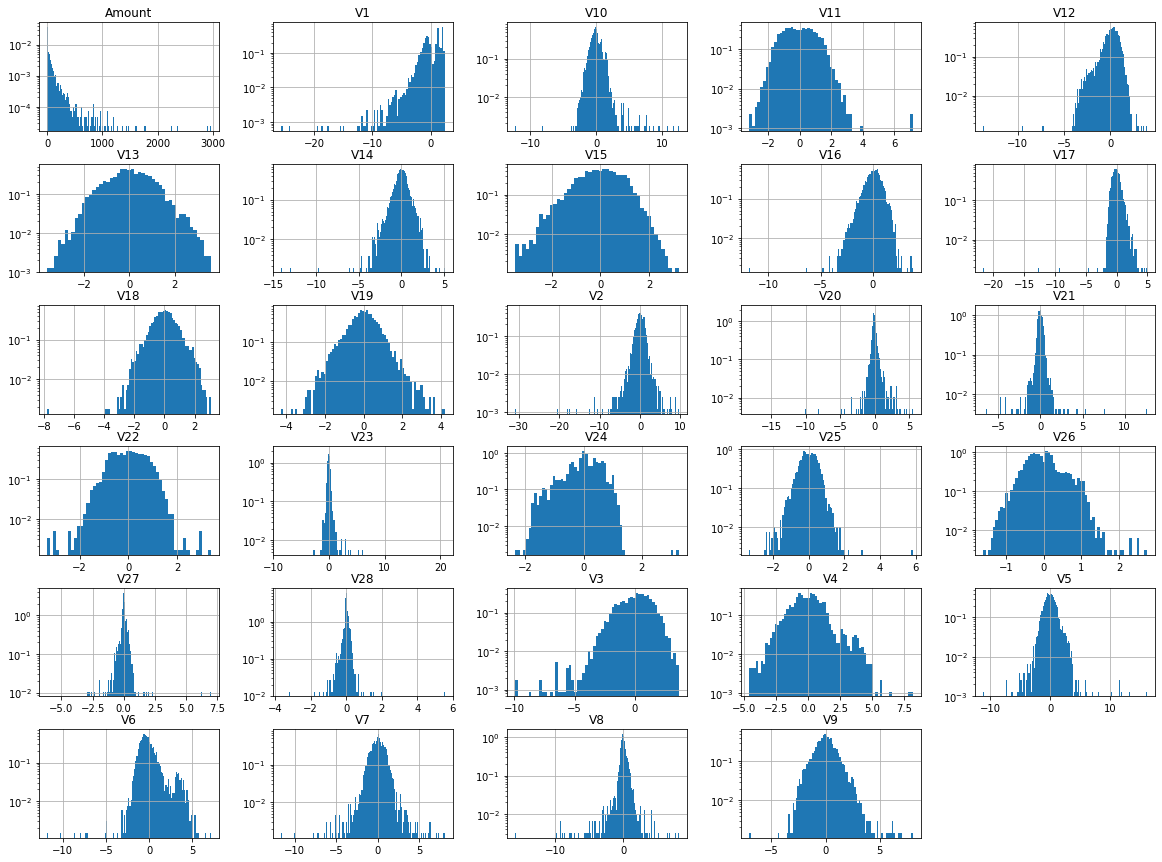

<IPython.core.display.Javascript object>

In [12]:
train_frame.sample(5000).hist(bins="auto", figsize=(20, 15), density=True, log=True)
plt.show()

* We could see our previous assumption that most of the values are centered around means
* Some of the features seems to follow "normal" distribution

### Visualization of dataset
* For visualization of the dataset we'll use dimension reduction methods as PCA, tSNE and UMAP
* We're use color map for points based on IsolationForest

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

In [14]:
scaled_frame = pd.DataFrame(
    StandardScaler().fit_transform(train_frame.values),
    index=train_frame.index,
    columns=train_frame.columns,
)

<IPython.core.display.Javascript object>

In [15]:
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Dissabling Numba warnning for UMAP (https://github.com/lmcinnes/umap/issues/252)
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [16]:
pca = PCA()
transformed = pca.fit_transform(scaled_frame.values)

<IPython.core.display.Javascript object>

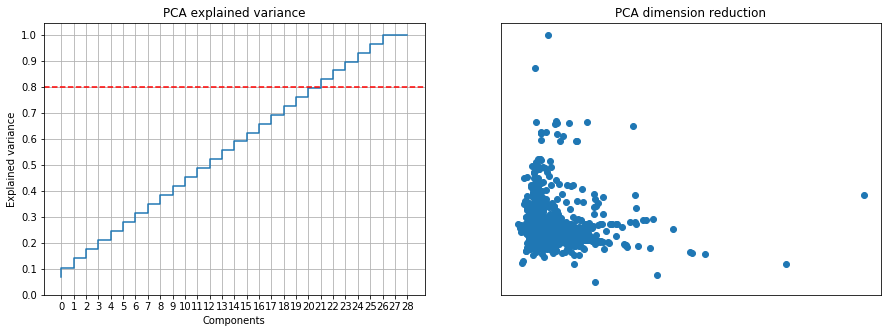

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

c_sum = np.cumsum(pca.explained_variance_)


ax[0].step(np.arange(c_sum.shape[0]), c_sum / c_sum[-1])
ax[0].grid()
ax[0].axhline(0.8, color="r", linestyle="--")

ax[0].set_title("PCA explained variance")
ax[0].set_xlabel("Components")
ax[0].set_ylabel("Explained variance")
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xticks(np.arange(0, c_sum.shape[0]))


ax[1].scatter(transformed[:, 0], transformed[:, 1])
ax[1].set_title("PCA dimension reduction")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

In [18]:
scaled_samples = scaled_frame.sample(1000)

<IPython.core.display.Javascript object>

In [19]:
iforest = IsolationForest(n_estimators=100)
iforest.fit(scaled_samples.values)

scores_ss = iforest.score_samples(scaled_samples.values)

sorted_index = np.argsort(scores_ss)[::-1]

<IPython.core.display.Javascript object>

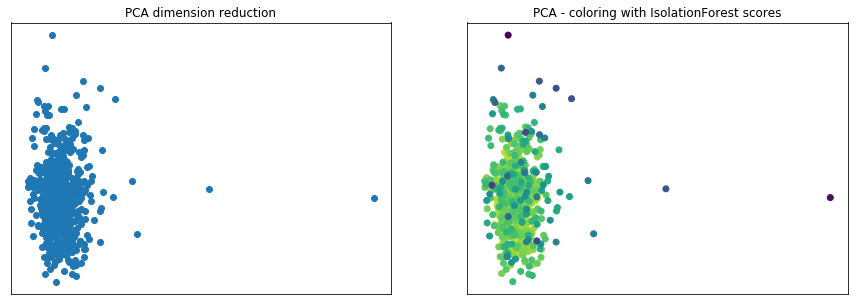

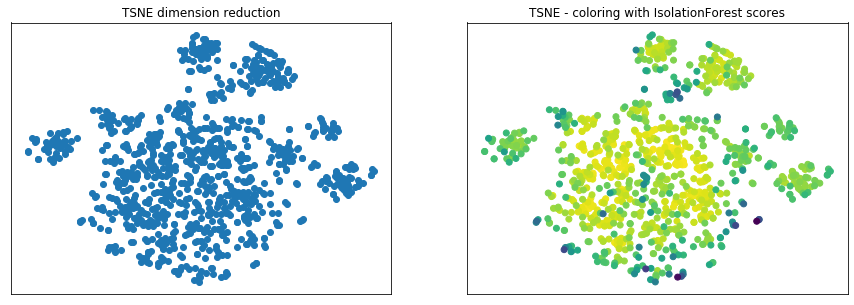

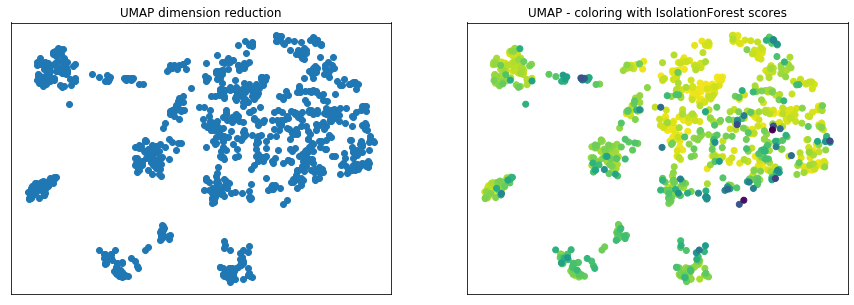

<IPython.core.display.Javascript object>

In [20]:
for trans in (PCA(n_components=2), TSNE(), UMAP()):

    transformed = trans.fit_transform(scaled_samples)

    transformed = transformed[sorted_index]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    name = type(trans).__name__

    ax[0].scatter(transformed[:, 0], transformed[:, 1])
    ax[0].set_title(f"{name} dimension reduction")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].scatter(transformed[:, 0], transformed[:, 1], c=scores_ss[sorted_index])
    ax[1].set_title(f"{name} - coloring with IsolationForest scores")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

#### PCA
* In PCA visualization we could see some "outliers", but because we're using just two features which is $< 20\%$ explained variance we cannot make any real assumptions
* Highlighting of the outliers from IsolationForest seems to be working good on this visualization. I suspect that really good highlighting could be a result of a common aspect of these methods. IsolationForest is making ensamples on "random projections" of the data. As suggested in [Pevný's LODA paper](https://link.springer.com/article/10.1007/s10994-015-5521-0) in high dimensional space these projections are approximately orthogonal which could be related to PCA.

#### tSNE & UMAP
* These methods tend to be better in visualizing the actual shape of the dataset
* We could see some clusters in the dataset. Outliers are part of these clusters or creating their small clusters

### Corelations

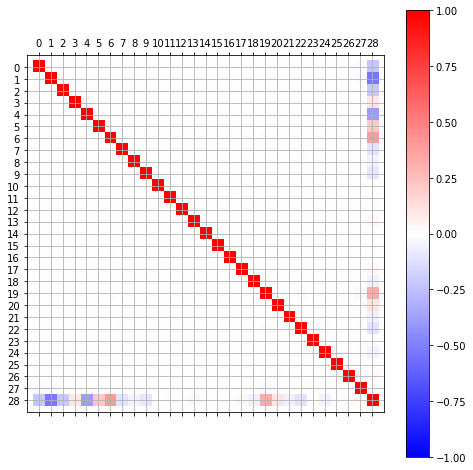

,V2,V5,V7,V20
Amount,-0.53,-0.39,0.4,0.33


<IPython.core.display.Javascript object>

In [21]:
corr = scaled_frame.corr()

fig = plt.figure(figsize=(8, 8))
plt.matshow(corr, fignum=fig.number, cmap="bwr", vmin=-1, vmax=1)
plt.grid()
plt.colorbar()

plt.xticks(np.arange(0, 29, 1))
plt.yticks(np.arange(28, -1, -1))

plt.xlim(-1, 29)
plt.ylim(29, -1)

plt.show()

crt = (corr[-1:].abs() > 0.25).sum().astype(bool)[:-1]


corr_frame = corr[crt.index[crt]][-1:]

corr_frame.style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

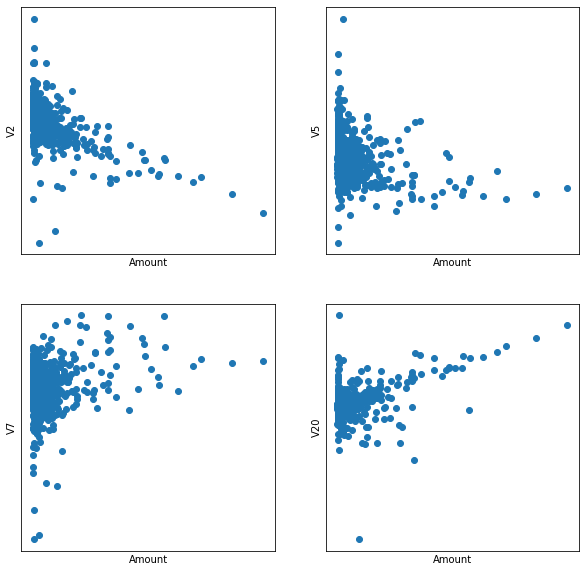

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for index, column in enumerate(corr_frame.columns):
    s_ax = ax[int(index / 2)][index % 2]
    s_ax.scatter(scaled_samples["Amount"].values, scaled_samples[column].values)

    s_ax.set_xticks([])
    s_ax.set_yticks([])
    s_ax.set_xlabel("Amount")
    s_ax.set_ylabel(column)

plt.show()

* We could see some weak correlations between Amount and some other features

## Task 4 - Anomaly detection (application task)

Using the above data, 

- train the isolation forest implemented above, the sklearn version of isolation forests and at least two other anomaly detection methods discussed in class on the credit card fraud data. 
- check their performance on the validation dataset. 
- discuss the performance of different methods.

### Task 4 Solution
* As detection methods I selected One Class SVM, Local Outlier Factor, Simplified LODA (Lightweight on-line detector of anomalies) and Elliptic Envelope

In [23]:
import time

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest as SkIsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.pipeline import Pipeline as SkPipeline

from sklearn.metrics import auc

from tqdm import tqdm_notebook as tqdm

<IPython.core.display.Javascript object>

Loading and checking validation and train dataset

In [24]:
test_frame = pd.read_csv("credit-card-fraud-validation.csv", index_col="Time")

<IPython.core.display.Javascript object>

In [25]:
test_frame[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0


<IPython.core.display.Javascript object>

In [26]:
data_columns = [column for column in test_frame.columns if column != "Class"]
print(data_columns)
np.all(data_columns == train_frame.columns)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


True

<IPython.core.display.Javascript object>

In [27]:
train_X = train_frame.values

<IPython.core.display.Javascript object>

In [28]:
test_X = test_frame[data_columns]
test_y = test_frame["Class"].values.astype(bool)

<IPython.core.display.Javascript object>

In [29]:
train_X.shape, test_X.shape, test_y.shape

((213605, 29), (71202, 29), (71202,))

<IPython.core.display.Javascript object>

Beccause time/space complexity of some methods is rising really quickly, we need to train it on subsample of real training data.

In [30]:
@dataclass
class SubSampler:
    n_samples: int = 1000  # number of output samples

    def fit(self, X: pd.DataFrame, *args, **kwarg) -> pd.DataFrame:
        return self

    def transform(self, X: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        res = pd.DataFrame(X)

        res = res.sample(self.n_samples)

        return res

<IPython.core.display.Javascript object>

`Pipeline` from Scikit-learn does not have a `score_samples` method

In [31]:
class Pipeline(SkPipeline):
    def score_samples(self, X: pd.DataFrame, *args, **kwargs) -> np.ndarray:
        res = X

        for _, step in self.steps:

            if isinstance(step, SubSampler):
                continue

            transform = getattr(step, "transform", None)
            if transform is not None:
                res = transform(X)

            score_samples = getattr(step, "score_samples", None)
            if score_samples is not None:
                return score_samples(X)

        return np.full(np.nan, res.shape[0])

<IPython.core.display.Javascript object>

In [32]:
import scipy


@dataclass
class SimpleLODA:
    """ Simplified LODA
    
    LODA: Lightweight on-line detector of anomalies
    https://link.springer.com/article/10.1007/s10994-015-5521-0
    """

    k: int
    bins: Union[int, str]
    d: int

    def __post_init__(self) -> SimpleLODA:
        self.weights = np.zeros((self.k, self.d))

        non_zero_w = np.rint(self.d * (self.d ** (-1 / 2))).astype(int)

        indexes = np.random.rand(self.k, self.d).argpartition(non_zero_w, axis=1)[
            :, :non_zero_w
        ]

        rand_values = np.random.normal(size=indexes.shape)

        for weight, chosen_d, values in zip(self.weights, indexes, rand_values):
            weight[chosen_d] = values

    def fit(self, X: Union[np.ndarray, pd.DataFrame]) -> SimpleLODA:

        if isinstance(X, pd.DataFrame):
            X = X.values

        w_X = X @ self.weights.T

        self.hists = [
            scipy.stats.rv_histogram(np.histogram(w_x, bins=self.bins)) for w_x in w_X.T
        ]

        return self

    def score_samples(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:

        if isinstance(X, pd.DataFrame):
            X = X.values

        w_X = X @ self.weights.T

        X_prob = np.array([hist.pdf(w_x) for hist, w_x in zip(self.hists, w_X.T)])
        X_prob[X_prob <= 0] = X_prob[X_prob > 0].min()

        X_scores = -np.mean(np.log(X_prob), axis=0)

        return -X_scores

<IPython.core.display.Javascript object>

In [33]:
detectors = (
    ("IsolationForest", IsolationForest(n_estimators=100)),
    (
        "SkIsolationForest",
        SkIsolationForest(n_estimators=100, contamination="auto", behaviour="new"),
    ),
    (
        "LocalOutlierFactor",
        Pipeline(
            [
                ("SubSampler", SubSampler(n_samples=10_000)),
                ("LOF", LocalOutlierFactor(contamination="auto", novelty=True)),
            ]
        ),
    ),
    (
        "OneClassSVM",
        Pipeline(
            [
                ("SubSampler", SubSampler(n_samples=10_000)),
                ("OneClassSVM", OneClassSVM()),
            ]
        ),
    ),
    ("SimpleLODA", SimpleLODA(k=100, bins="auto", d=train_frame.shape[1])),
    (
        "EllipticEnvelope",
        Pipeline(
            [
                ("SubSampler", SubSampler(n_samples=10_000)),
                ("EllipticEnvelope", EllipticEnvelope()),
            ]
        ),
    ),
)

<IPython.core.display.Javascript object>

In [34]:
stats = {}

for name, detector in tqdm(detectors, desc="Progress"):

    t_fit_start = time.process_time()
    detector.fit(train_X)
    t_fit_end = time.process_time()

    t_score_start = time.process_time()
    scores = detector.score_samples(test_X)
    t_score_end = time.process_time()

    tp_rate = np.cumsum(test_y[np.argsort(scores)]) / np.sum(test_y)
    fp_rate = np.cumsum(test_y[np.argsort(scores)] == 0) / np.sum(test_y == 0)

    auc_score = auc(fp_rate, tp_rate)

    stats[name] = {
        "fp_rate": fp_rate,
        "tp_rate": tp_rate,
        "auc": auc_score,
        "train_time": t_fit_end - t_fit_start,
        "test_time": t_score_end - t_score_start,
    }

<IPython.core.display.Javascript object>

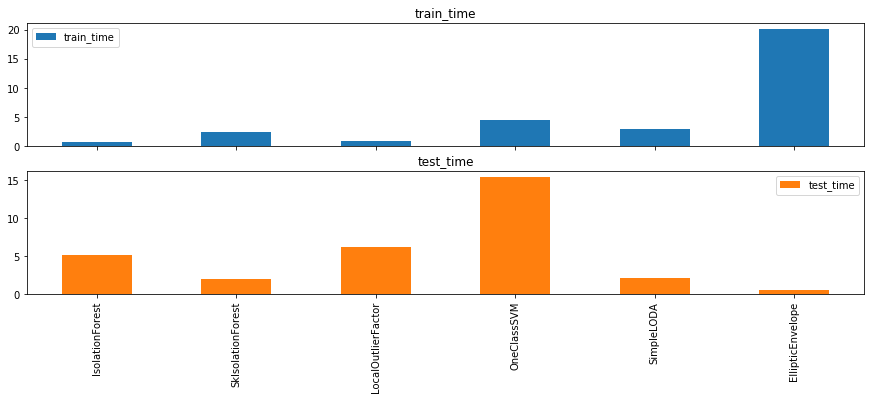

,train_time,test_time
IsolationForest,0.740047,5.11351
SkIsolationForest,2.39778,1.97872
LocalOutlierFactor,0.924519,6.27989
OneClassSVM,4.45057,15.425
SimpleLODA,2.90357,2.12343
EllipticEnvelope,20.229,0.596119


<IPython.core.display.Javascript object>

In [35]:
pd.DataFrame(stats).T[["train_time", "test_time"]].plot.bar(
    figsize=(15, 5), subplots=True
)
plt.show()
pd.DataFrame(stats).T[["train_time", "test_time"]]

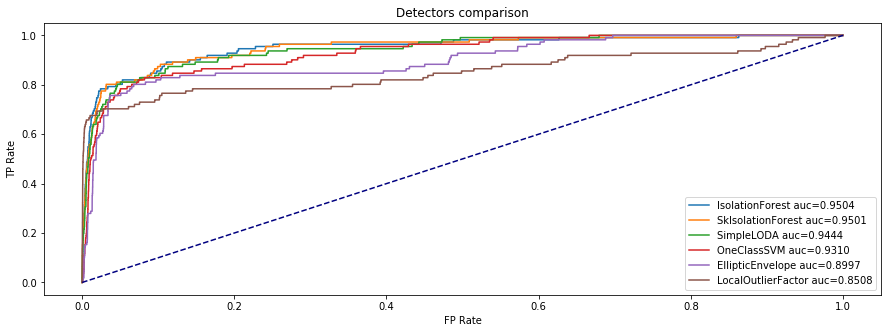

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(15, 5))

sorted_stats = sorted(stats.items(), key=lambda x: x[1]["auc"], reverse=True)


for name, stat in sorted_stats:
    auc_score = stat["auc"]
    plt.plot(stat["fp_rate"], stat["tp_rate"], label=f"{name} auc={auc_score:.4f}")


plt.title(f"Detectors comparison")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.legend(loc="lower right")
plt.show()

* Almost all methods seem to perform really similar except for Local Outlier Factor and Elliptic Envelope. Ensemble methods seem to be a little bit better.
    * **LOC** 
        * It looks like TP rate of LOF is rising fastest at the begging but afterward it's struggling to find more of them
        * LOC is not really  a novelty detection method rather outlier detection method on the same data it was trained on
    * **EllipticEnvelope**
        * Weaker performance may be caused by the high dimensionality of the data or strange distributions of some features
    * **OneClassSVM**
        * Performance may be enhanced by cleaning input dataset from outliers or increasing number of training samples